# Deep Learning Tutorial <br> Day 4. CIFAR10 Classification

Written by Nuri Kim.
This code can be downloaded from [GitHub](https://github.com/bareblackfoot/deep_learning_tutorial).

References of this notebook: 
*TensorFlow-Tutorials by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)* and 
*CIFAR-10 by [dhanushkamath](https://github.com/dhanushkamath/CIFAR-10/blob/master/Cifar10.ipynb)*

## Introduction

This tutorial demonstrates the workflow of an image classification using TensorFlow with convolutional networks. Unlike MNIST dataset, CIFAR10 dataset has color images of 10 categories. Here, we define and optimize a simple mathematical model in TensorFlow. The results are then plotted.

## Imports

In [1]:
from glob import glob
from time import time
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
try:
    from urllib.request import urlretrieve
except:
    from urllib import urlretrieve
import pandas as pd
import numpy as np
import sys, os, math
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import itertools
import tarfile
import pickle

print ("Packages loaded")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Packages loaded


### Set parameters

In [2]:
# PARAMS
_BATCH_SIZE = 32
_EPOCH = 10
_SNAPSHOT_PREFIX = "cifar10"
_NUM_VIS_EMBEDDING = 500
_IMAGE_HEIGHT = 32
_IMAGE_WIDTH = 32
_IMAGE_CHANNELS = 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
_NUM_CLASSES = len(class_names)
class_to_num = dict(zip(class_names, range(_NUM_CLASSES)))
num_to_class = dict(zip(range(_NUM_CLASSES), class_names))
lr = 1e-3

This was developed using Python 3.5 and TensorFlow version 1.10. Please check yours:

In [3]:
tf.__version__

'1.10.1'

### Helper-functions for loading images

Functions used to download dataset and pre-process images.

In [4]:
def get_data_set(name="train"):
    x = y = None
    maybe_download_and_extract()
    folder_name = "cifar10"
    f = open('./data/'+folder_name+'/batches.meta', 'rb')
    f.close()

    if name is "train":
        for i in range(5):
            f = open('./data/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
            try:
                datadict = pickle.load(f, encoding='latin1') 
            except:
                datadict = pickle.load(f)
            f.close()

            _X = datadict["data"]
            _Y = datadict['labels']

            _X = np.array(_X, dtype=float) / 255.0
            _X = _X.reshape([-1, _IMAGE_CHANNELS, _IMAGE_HEIGHT, _IMAGE_WIDTH])
            _X = _X.transpose([0, 2, 3, 1])
            _X = _X.reshape(-1, _IMAGE_HEIGHT*_IMAGE_WIDTH*_IMAGE_CHANNELS)

            if x is None:
                x = _X
                y = _Y
            else:
                x = np.concatenate((x, _X), axis=0)
                y = np.concatenate((y, _Y), axis=0)

    elif name is "test":
        f = open('./data/'+folder_name+'/test_batch', 'rb')
        try:
            datadict = pickle.load(f, encoding='latin1') 
        except:
            datadict = pickle.load(f)
        f.close()
        x = datadict["data"]
        y = np.array(datadict['labels'])
        x = np.array(x, dtype=float) / 255.0
        x = x.reshape([-1, _IMAGE_CHANNELS, _IMAGE_HEIGHT, _IMAGE_WIDTH])
        x = x.transpose([0, 2, 3, 1])
        x = x.reshape(-1, _IMAGE_HEIGHT*_IMAGE_WIDTH*_IMAGE_CHANNELS)

    return x, dense_to_one_hot(y)

def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def maybe_download_and_extract():
    main_directory = "./data/"
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)
    cifar_10_directory = main_directory+"cifar10/"
    if not os.path.exists(cifar_10_directory):
        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_10 = file_path
        file_path, _ = urlretrieve(url=url, filename=file_path, 
                                   reporthook=print_download_progress)

        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")

        os.rename(main_directory+"cifar-10-batches-py", cifar_10_directory)
        os.remove(zip_cifar_10)

## Load Data
The size of CIFAR10 dataset is about  180MB and it will be downloaded automatically if it is not located in the given path.

In [5]:
train_x, train_y = get_data_set("train")
test_x, test_y = get_data_set("test")

print ("Dataset loaded")

Dataset loaded


The CIFAR10 dataset has now been loaded and consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

### Plot a few images to see if data is correct

(50000, 3072)
(50000, 10)


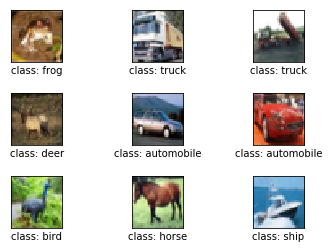

In [6]:
def show_images():
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(train_x[i].reshape(_IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS))
        
        # Name of the true class.
        cls_true_name = num_to_class[train_y[i].argmax()]
        xlabel = "class: {0}".format(cls_true_name)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    return

print(train_x.shape)
print(train_y.shape)
show_images()

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to feed input into the graph.
* Model variables that are going to be optimized so as to make the model perform better.
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A loss measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard.

### Placeholder variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, _IMAGE_HEIGHT * _IMAGE_WIDTH * _IMAGE_CHANNEL]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `_IMAGE_HEIGHT * _IMAGE_WIDTH * _IMAGE_CHANNEL`.

In [7]:
x = tf.placeholder(tf.float32, shape=[None, _IMAGE_HEIGHT * _IMAGE_WIDTH * _IMAGE_CHANNELS], name='Input')

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, _NUM_CLASSES]` which means it may hold an arbitrary number of labels and each label is a vector of length `_NUM_CLASSES` which is 10 in this case.

In [8]:
y_true = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='Output')

Since we use a dropout regularization method for a fully connected layer, we have the placeholder variable for the probability to keep variables. If `keep_probability` is 1.0, all variables are the same without the dropout regularization. When `keep_probability` is 0.5, half of the variables in a fully connected layer become 0.0.    

In [9]:
keep_probability = tf.placeholder(tf.float32, shape=[], name='keep_prob')

`global_step` saves how many optimization iterations are used.

In [10]:
global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')

Tensorflow takes an image input in order of `[Batch, _IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNEL]`. We reshape the input image to make the tensorflow graph can understand the input. 

In [11]:
x_image = tf.reshape(x, [-1, _IMAGE_HEIGHT, _IMAGE_WIDTH, _IMAGE_CHANNELS], name='images')

### Network model  to be optimized

The network consists of `4` convolutional networks and `2` fully connected layers. `conv1_1` layer consists of  filters with weight size `[3, 3, 3, 32]` and bias for each output channel, size `[32]`. `conv1_2` layer consists of filters with weight size `[3, 3, 32, 32]` and bias for each output channel, size `[32]`. `conv2_1` layer contains filters with size `[3, 3, 32, 64]` and bias for each output channel, size `[64]`. `conv2_2` layer consists of filters with size `[3, 3, 64, 64]` and bias for each output channel, size `[64]`. `fully_connected` layer has a filter with weight size `[_IMAGE_HEIGHT/4 * _IMAGE_WIDTH/4 * 64, 1000]`, and bias for each output channel, size 1000. Lastly, the `feat` layer has a filter with weight size `[1000, 10]` and bias for each output channel, size `[10]`.

In [12]:
# [Exercise 1] Change the CNN architecture to VGG16 
# Answer: VGG16 network
with tf.variable_scope('vgg_16'):
    feat = slim.repeat(x_image, 2, slim.conv2d, 64, [3, 3], scope='conv1')
    feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool1')
    feat = slim.repeat(feat, 2, slim.conv2d, 128, [3, 3], scope='conv2')
    feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool2')
    feat = slim.repeat(feat, 3, slim.conv2d, 256, [3, 3], scope='conv3')
    feat = slim.max_pool2d(feat, [2, 2], padding='SAME', scope='pool3')
feat = slim.flatten(feat, scope='flatten')
feat = slim.fully_connected(feat, 1000, scope='fully_connected')

In [13]:
# [Exercise 2] Add a regularization method
# Choose one of the regularization methods (Batch normalization, Dropout).
# Answer: Batch Normalization
feat = slim.batch_norm(feat, scope='batch_norm')

# Answer: Dropout
# feat = slim.dropout(feat, keep_probability, scope='dropout')

In [14]:
y_pred = slim.fully_connected(feat, _NUM_CLASSES, scope='feat', activation_fn=None)
softmax = tf.nn.softmax(y_pred)
y_pred_cls = tf.argmax(softmax, axis=1)

Let's see the variables in the network model which we defined above.

In [15]:
print(tf.global_variables())

[<tf.Variable 'global_step:0' shape=() dtype=int32_ref>, <tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_1/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/

### Loss-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for `weights` and `biases`. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the `weights` and `biases` of the model.

TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the `logits` because it also calculates the softmax internally.

In [16]:
try:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y_true)
except:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [17]:
loss = tf.reduce_mean(cross_entropy)

In [18]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

### Optimization method

Now that we have a loss measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the learning rate (step-size) is set to 0.001.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [19]:
global_accuracy = 0
epoch_start = 0

# [Exercise 3] Define an optimizer
# Answer: Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08).minimize(loss, global_step=global_step)

# Answer: Momentum optimizer
# optimizer = tf.train.MomentumOptimizer(learning_rate=lr, 
#                                        momentum=0.9).minimize(loss, global_step=global_step)

# Answer: RMSProp optimizer
# optimizer = tf.train.RMSPropOptimizer(learning_rate=lr, 
#                                       decay=0.9,
#                                       momentum=0.5,
#                                       epsilon=1e-8).minimize(loss, global_step=global_step)

### Performance measures

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [20]:
correct_prediction = tf.equal(y_pred_cls, tf.argmax(y_true, axis=1))

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [21]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))*100.0

In [22]:
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [23]:
sess = tf.Session()

### Initialize network parameters

The variables for `weights` and `biases` in convolutional networks and fully connected layers must be initialized before we start optimizing them.

Use either Cell 24 or Cell 25.

In [24]:
# sess.run(tf.global_variables_initializer())
# print("Initialized variables.")

In [25]:
# [Bonus Exercise] Load pretrained VGG16 networks
# Use this block when you want to use pretrained VGG networks
if not os.path.isfile("./data/vgg_16.ckpt"):
    urlretrieve(url="http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz", filename="./data/vgg_16_2016_08_28.tar.gz", reporthook=print_download_progress)
    print()
    print("Download finished. Extracting files.")
    tarfile.open(name="./data/vgg_16_2016_08_28.tar.gz", mode="r:gz").extractall("./data/")
    os.remove("./data/vgg_16_2016_08_28.tar.gz")
    print("Done.")
sess.run(tf.global_variables_initializer())
from tensorflow.python import pywrap_tensorflow
reader = pywrap_tensorflow.NewCheckpointReader("./data/vgg_16.ckpt")
var_to_shape_map = reader.get_variable_to_shape_map()
for key in sorted(var_to_shape_map):
    with tf.variable_scope("", reuse=tf.AUTO_REUSE):
        try:
            var = tf.get_variable(key)
            sess.run(var.assign(reader.get_tensor(key)))
            print("assign pretrain model " + key)
        except ValueError:
            print("ignore " + key)
print("Initialized variables with pretrained model.")

ignore global_step
assign pretrain model vgg_16/conv1/conv1_1/biases
assign pretrain model vgg_16/conv1/conv1_1/weights
assign pretrain model vgg_16/conv1/conv1_2/biases
assign pretrain model vgg_16/conv1/conv1_2/weights
assign pretrain model vgg_16/conv2/conv2_1/biases
assign pretrain model vgg_16/conv2/conv2_1/weights
assign pretrain model vgg_16/conv2/conv2_2/biases
assign pretrain model vgg_16/conv2/conv2_2/weights
assign pretrain model vgg_16/conv3/conv3_1/biases
assign pretrain model vgg_16/conv3/conv3_1/weights
assign pretrain model vgg_16/conv3/conv3_2/biases
assign pretrain model vgg_16/conv3/conv3_2/weights
assign pretrain model vgg_16/conv3/conv3_3/biases
assign pretrain model vgg_16/conv3/conv3_3/weights
ignore vgg_16/conv4/conv4_1/biases
ignore vgg_16/conv4/conv4_1/weights
ignore vgg_16/conv4/conv4_2/biases
ignore vgg_16/conv4/conv4_2/weights
ignore vgg_16/conv4/conv4_3/biases
ignore vgg_16/conv4/conv4_3/weights
ignore vgg_16/conv5/conv5_1/biases
ignore vgg_16/conv5/conv5_

### Helper-functions to plot results

Function for plotting confusion matrix of test images.

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print('Drawing confusion matrix...')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Function for plotting tsne examples of test images.

In [27]:
def plot_tsne(y_pred_val, y_true_val):
    numbered = LabelEncoder().fit_transform(list(y_true_val))
    c = plt.cm.get_cmap('hsv', len(set(numbered)))
    colors=[]
    for num in numbered:
        temp=c(num)
        colors.append(temp)
        
    print('Fitting TSNE...')
    X_embedded = TSNE(n_components=2).fit_transform(y_pred_val[:10000])
    X_embedded = np.array(X_embedded)
    vis_x = X_embedded[:, 0]
    vis_y = X_embedded[:, 1]
    numbered = LabelEncoder().fit_transform(list(y_true_val))
    c = plt.cm.get_cmap('hsv', len(set(numbered)))
    plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(vis_x, vis_y, c=colors,alpha=1,linewidths=1,s=10, edgecolors='none')
    plt.show()
    return X_embedded

### Helper-function to test the model at the middle of training

In [28]:
def test(_global_step, epoch, y_pred_val, y_true_val):
    global global_accuracy
    global epoch_start

    i = 0
    predicted_class = np.zeros(shape=len(test_x), dtype=np.int)
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        predicted_class[i:j] = sess.run(
            y_pred_cls,
            feed_dict={x: batch_xs, y_true: batch_ys, keep_probability: 1.0}
        )    
        i = j
    text_y_argmax = np.argmax(test_y, axis=1)  
    correct = (text_y_argmax == predicted_class)
    acc = correct.mean()*100
    correct_numbers = correct.sum()

    hours, rem = divmod(time() - epoch_start, 3600)
    minutes, seconds = divmod(rem, 60)
    mes = "\nEpoch {} - accuracy: {:.1f}% ({}/{}) - time: {:0>2}:{:0>2}:{:05.2f}"
    print(mes.format((epoch+1), acc, correct_numbers, len(test_x), int(hours), int(minutes), seconds))

    if global_accuracy != 0 and global_accuracy < acc:
        mes = "This epoch receive better accuracy: {:.1f}% > {:.1f}%."
        print(mes.format(acc, global_accuracy))
        global_accuracy = acc

    elif global_accuracy == 0:
        global_accuracy = acc
        
    # Plot non-normalized confusion matrix
    cnf_matrix = confusion_matrix(text_y_argmax, predicted_class)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    plot_tsne(y_pred_val, y_true_val)
    
    print("###########################################################################################################")

### Helper-function to perform optimization iterations

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `biases` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [29]:
def train(epoch):
    global epoch_start
    epoch_start = time()
    batch_size = int(math.ceil(len(train_x) / _BATCH_SIZE))
    i_global = 0

    for s in range(batch_size):
        batch_xs = train_x[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]
        batch_ys = train_y[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]

        start_time = time()
        i_global, _, batch_loss, batch_acc = sess.run(
            [global_step, optimizer, loss, accuracy],
            feed_dict={x: batch_xs, y_true: batch_ys, keep_probability: 0.5})
        duration = time() - start_time
        summary_eval = sess.run(tf_summary_op, feed_dict={x: batch_xs, y_true: batch_ys, keep_probability: 1.0})
        writer.add_summary(summary_eval, epoch*batch_size + s)

        if s % 100 == 0:
            percentage = int(float(s)/float(batch_size)*100.0)
            bar_len = 29
            filled_len = int((bar_len*int(percentage))/100)
            bar = '=' * filled_len + '>' + '-' * (bar_len - filled_len)

            msg = "Global step: {:>5} - [{}] {:>3}% - accuracy: {:.1f}% - loss: {:.4f} - {:.1f} sample/sec"
            print(msg.format(i_global, bar, percentage, batch_acc, batch_loss, _BATCH_SIZE / duration))
    y_pred_val = sess.run(y_pred, feed_dict={x: train_x[:_NUM_VIS_EMBEDDING], keep_probability: 1.0})
    y_true_val = train_y[:_NUM_VIS_EMBEDDING]
    y_true_val = y_true_val.argmax(1)

    test(i_global, epoch, y_pred_val, y_true_val)

### Start training networks

Weights are optimized and the accuracy on the test set increases as global step increases.

In [30]:
tf_summary_op = tf.summary.merge_all()
tensorboard_path = './tensorboard'
if not os.path.exists(tensorboard_path):
    os.mkdir(tensorboard_path)
writer = tf.summary.FileWriter(tensorboard_path, sess.graph)

Start training

Epoch: 1/10

Global step:     1 - [>-----------------------------]   0% - accuracy: 9.4% - loss: 3.0225 - 37.8 sample/sec
Global step:   101 - [=>----------------------------]   6% - accuracy: 40.6% - loss: 1.6255 - 3240.6 sample/sec
Global step:   201 - [===>--------------------------]  12% - accuracy: 53.1% - loss: 1.2482 - 3207.0 sample/sec
Global step:   301 - [=====>------------------------]  19% - accuracy: 65.6% - loss: 1.1519 - 3261.3 sample/sec
Global step:   401 - [=======>----------------------]  25% - accuracy: 62.5% - loss: 1.1277 - 3009.4 sample/sec
Global step:   501 - [========>---------------------]  31% - accuracy: 56.2% - loss: 1.3634 - 3034.0 sample/sec
Global step:   601 - [===========>------------------]  38% - accuracy: 56.2% - loss: 1.2899 - 3172.2 sample/sec
Global step:   701 - [============>-----------------]  44% - accuracy: 53.1% - loss: 1.1423 - 3266.2 sample/sec
Global step:   801 - [==============>---------------]  51% - accuracy: 56.2% -

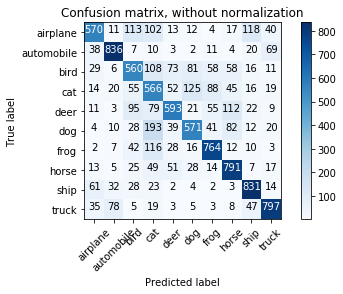

Fitting TSNE...


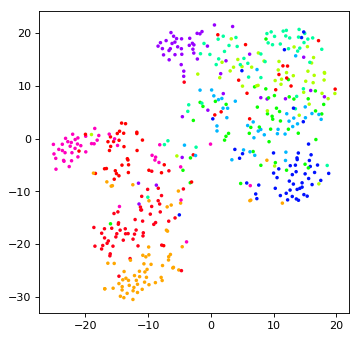

###########################################################################################################

Epoch: 2/10

Global step:  1564 - [>-----------------------------]   0% - accuracy: 78.1% - loss: 0.6535 - 2349.9 sample/sec
Global step:  1664 - [=>----------------------------]   6% - accuracy: 68.8% - loss: 1.1024 - 3219.0 sample/sec
Global step:  1764 - [===>--------------------------]  12% - accuracy: 62.5% - loss: 0.9688 - 2069.2 sample/sec
Global step:  1864 - [=====>------------------------]  19% - accuracy: 46.9% - loss: 1.3745 - 3277.3 sample/sec
Global step:  1964 - [=======>----------------------]  25% - accuracy: 68.8% - loss: 0.7566 - 3247.5 sample/sec
Global step:  2064 - [========>---------------------]  31% - accuracy: 65.6% - loss: 0.8969 - 2376.5 sample/sec
Global step:  2164 - [===========>------------------]  38% - accuracy: 71.9% - loss: 0.9186 - 3284.8 sample/sec
Global step:  2264 - [============>-----------------]  44% - accuracy: 62.5% - loss: 0.9645 - 

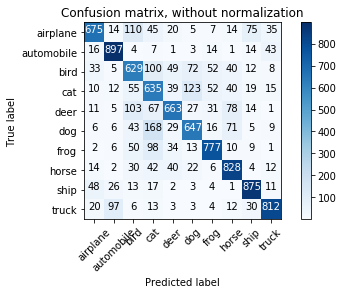

Fitting TSNE...


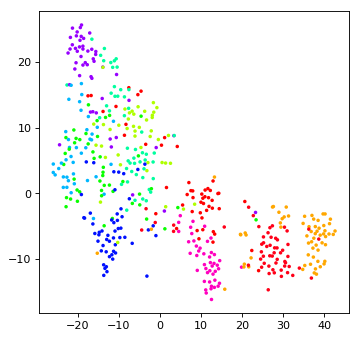

###########################################################################################################

Epoch: 3/10

Global step:  3127 - [>-----------------------------]   0% - accuracy: 81.2% - loss: 0.3765 - 2034.9 sample/sec
Global step:  3227 - [=>----------------------------]   6% - accuracy: 75.0% - loss: 0.7931 - 3064.5 sample/sec
Global step:  3327 - [===>--------------------------]  12% - accuracy: 71.9% - loss: 0.7579 - 3169.1 sample/sec
Global step:  3427 - [=====>------------------------]  19% - accuracy: 78.1% - loss: 0.4879 - 3086.0 sample/sec
Global step:  3527 - [=======>----------------------]  25% - accuracy: 78.1% - loss: 0.5102 - 3257.8 sample/sec
Global step:  3627 - [========>---------------------]  31% - accuracy: 81.2% - loss: 0.6812 - 3196.0 sample/sec
Global step:  3727 - [===========>------------------]  38% - accuracy: 75.0% - loss: 0.8819 - 2898.9 sample/sec
Global step:  3827 - [============>-----------------]  44% - accuracy: 81.2% - loss: 0.6656 - 

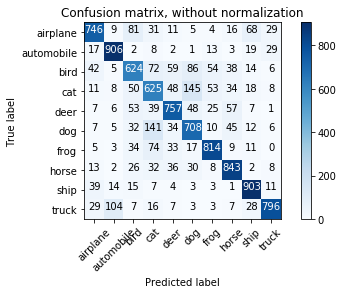

Fitting TSNE...


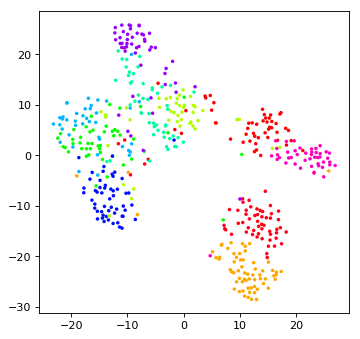

###########################################################################################################

Epoch: 4/10

Global step:  4690 - [>-----------------------------]   0% - accuracy: 90.6% - loss: 0.2077 - 2711.3 sample/sec
Global step:  4790 - [=>----------------------------]   6% - accuracy: 62.5% - loss: 1.0354 - 3278.6 sample/sec
Global step:  4890 - [===>--------------------------]  12% - accuracy: 59.4% - loss: 0.9371 - 3262.6 sample/sec
Global step:  4990 - [=====>------------------------]  19% - accuracy: 62.5% - loss: 1.0788 - 2973.4 sample/sec
Global step:  5090 - [=======>----------------------]  25% - accuracy: 75.0% - loss: 0.6129 - 2021.9 sample/sec
Global step:  5190 - [========>---------------------]  31% - accuracy: 68.8% - loss: 0.8658 - 3202.1 sample/sec
Global step:  5290 - [===========>------------------]  38% - accuracy: 84.4% - loss: 0.6611 - 3299.5 sample/sec
Global step:  5390 - [============>-----------------]  44% - accuracy: 90.6% - loss: 0.5523 - 

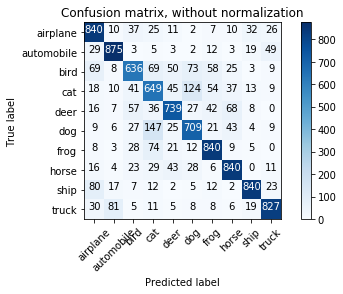

Fitting TSNE...


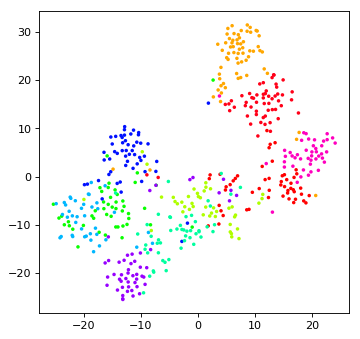

###########################################################################################################

Epoch: 5/10

Global step:  6253 - [>-----------------------------]   0% - accuracy: 96.9% - loss: 0.2331 - 2223.1 sample/sec
Global step:  6353 - [=>----------------------------]   6% - accuracy: 75.0% - loss: 0.6245 - 3250.8 sample/sec
Global step:  6453 - [===>--------------------------]  12% - accuracy: 75.0% - loss: 0.6405 - 3258.7 sample/sec
Global step:  6553 - [=====>------------------------]  19% - accuracy: 84.4% - loss: 0.4036 - 3155.3 sample/sec
Global step:  6653 - [=======>----------------------]  25% - accuracy: 81.2% - loss: 0.3302 - 2801.8 sample/sec
Global step:  6753 - [========>---------------------]  31% - accuracy: 84.4% - loss: 0.6197 - 3148.5 sample/sec
Global step:  6853 - [===========>------------------]  38% - accuracy: 81.2% - loss: 0.4771 - 2940.2 sample/sec
Global step:  6953 - [============>-----------------]  44% - accuracy: 84.4% - loss: 0.5086 - 

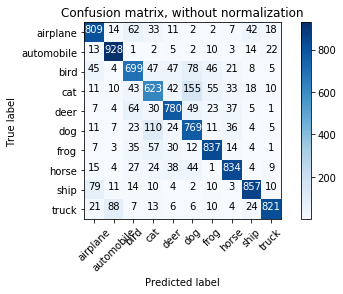

Fitting TSNE...


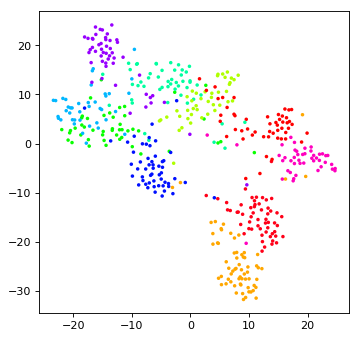

###########################################################################################################

Epoch: 6/10

Global step:  7816 - [>-----------------------------]   0% - accuracy: 93.8% - loss: 0.2716 - 2517.6 sample/sec
Global step:  7916 - [=>----------------------------]   6% - accuracy: 78.1% - loss: 0.4831 - 3266.0 sample/sec
Global step:  8016 - [===>--------------------------]  12% - accuracy: 81.2% - loss: 0.5111 - 3252.2 sample/sec
Global step:  8116 - [=====>------------------------]  19% - accuracy: 84.4% - loss: 0.2935 - 3291.0 sample/sec
Global step:  8216 - [=======>----------------------]  25% - accuracy: 93.8% - loss: 0.2771 - 3156.9 sample/sec
Global step:  8316 - [========>---------------------]  31% - accuracy: 84.4% - loss: 0.7190 - 3264.4 sample/sec
Global step:  8416 - [===========>------------------]  38% - accuracy: 90.6% - loss: 0.3998 - 3243.7 sample/sec
Global step:  8516 - [============>-----------------]  44% - accuracy: 81.2% - loss: 0.4967 - 

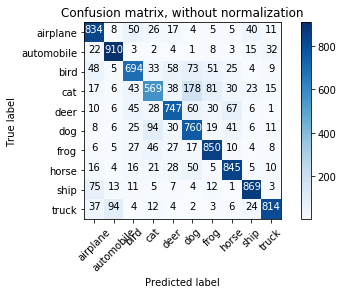

Fitting TSNE...


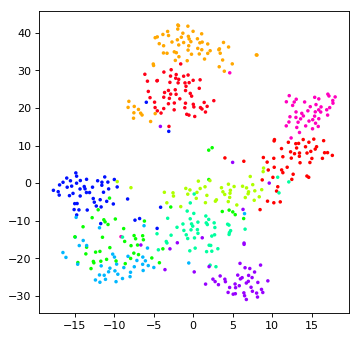

###########################################################################################################

Epoch: 7/10

Global step:  9379 - [>-----------------------------]   0% - accuracy: 90.6% - loss: 0.2608 - 2622.4 sample/sec
Global step:  9479 - [=>----------------------------]   6% - accuracy: 81.2% - loss: 0.3745 - 3286.9 sample/sec
Global step:  9579 - [===>--------------------------]  12% - accuracy: 81.2% - loss: 0.4409 - 3301.9 sample/sec
Global step:  9679 - [=====>------------------------]  19% - accuracy: 90.6% - loss: 0.1697 - 3143.1 sample/sec
Global step:  9779 - [=======>----------------------]  25% - accuracy: 87.5% - loss: 0.3526 - 3116.4 sample/sec
Global step:  9879 - [========>---------------------]  31% - accuracy: 87.5% - loss: 0.5030 - 3205.7 sample/sec
Global step:  9979 - [===========>------------------]  38% - accuracy: 87.5% - loss: 0.3433 - 3281.8 sample/sec
Global step: 10079 - [============>-----------------]  44% - accuracy: 93.8% - loss: 0.3544 - 

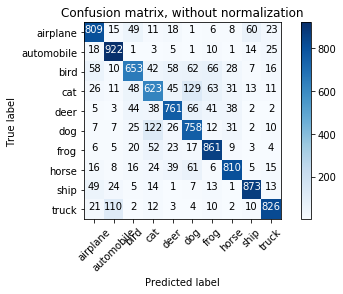

Fitting TSNE...


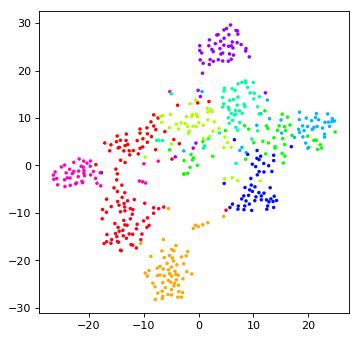

###########################################################################################################

Epoch: 8/10

Global step: 10942 - [>-----------------------------]   0% - accuracy: 93.8% - loss: 0.2206 - 2325.7 sample/sec
Global step: 11042 - [=>----------------------------]   6% - accuracy: 84.4% - loss: 0.3063 - 3061.4 sample/sec
Global step: 11142 - [===>--------------------------]  12% - accuracy: 84.4% - loss: 0.5008 - 3221.6 sample/sec
Global step: 11242 - [=====>------------------------]  19% - accuracy: 87.5% - loss: 0.1480 - 3112.4 sample/sec
Global step: 11342 - [=======>----------------------]  25% - accuracy: 93.8% - loss: 0.1521 - 3246.1 sample/sec
Global step: 11442 - [========>---------------------]  31% - accuracy: 90.6% - loss: 0.4968 - 2848.4 sample/sec
Global step: 11542 - [===========>------------------]  38% - accuracy: 75.0% - loss: 0.7957 - 3194.7 sample/sec
Global step: 11642 - [============>-----------------]  44% - accuracy: 96.9% - loss: 0.2395 - 

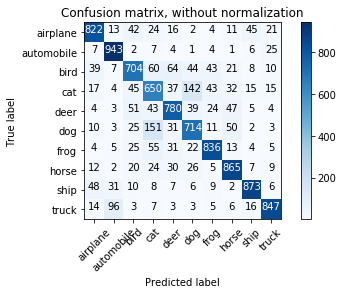

Fitting TSNE...


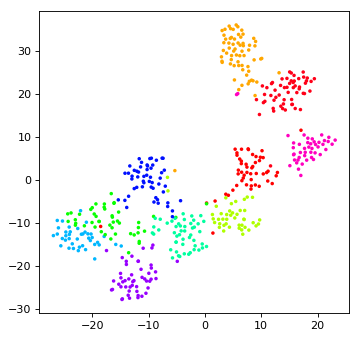

###########################################################################################################

Epoch: 9/10

Global step: 12505 - [>-----------------------------]   0% - accuracy: 100.0% - loss: 0.0648 - 2675.6 sample/sec
Global step: 12605 - [=>----------------------------]   6% - accuracy: 87.5% - loss: 0.1933 - 3310.2 sample/sec
Global step: 12705 - [===>--------------------------]  12% - accuracy: 87.5% - loss: 0.2516 - 3241.2 sample/sec
Global step: 12805 - [=====>------------------------]  19% - accuracy: 100.0% - loss: 0.0554 - 3259.0 sample/sec
Global step: 12905 - [=======>----------------------]  25% - accuracy: 84.4% - loss: 0.5857 - 3250.3 sample/sec
Global step: 13005 - [========>---------------------]  31% - accuracy: 93.8% - loss: 0.2575 - 3241.0 sample/sec
Global step: 13105 - [===========>------------------]  38% - accuracy: 81.2% - loss: 0.4259 - 2174.6 sample/sec
Global step: 13205 - [============>-----------------]  44% - accuracy: 93.8% - loss: 0.1197 

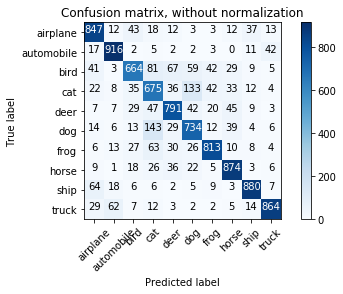

Fitting TSNE...


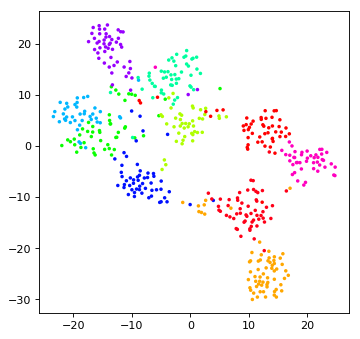

###########################################################################################################

Epoch: 10/10

Global step: 14068 - [>-----------------------------]   0% - accuracy: 93.8% - loss: 0.1608 - 2451.8 sample/sec
Global step: 14168 - [=>----------------------------]   6% - accuracy: 87.5% - loss: 0.3491 - 3233.9 sample/sec
Global step: 14268 - [===>--------------------------]  12% - accuracy: 90.6% - loss: 0.3653 - 3251.6 sample/sec
Global step: 14368 - [=====>------------------------]  19% - accuracy: 100.0% - loss: 0.0869 - 3253.8 sample/sec
Global step: 14468 - [=======>----------------------]  25% - accuracy: 96.9% - loss: 0.1262 - 3252.4 sample/sec
Global step: 14568 - [========>---------------------]  31% - accuracy: 96.9% - loss: 0.1350 - 3280.3 sample/sec
Global step: 14668 - [===========>------------------]  38% - accuracy: 93.8% - loss: 0.1952 - 3199.5 sample/sec
Global step: 14768 - [============>-----------------]  44% - accuracy: 87.5% - loss: 0.3359 

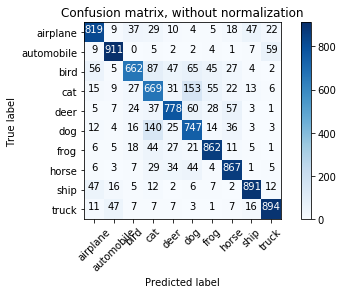

Fitting TSNE...


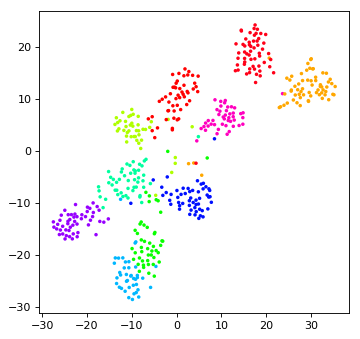

###########################################################################################################
Best accuracy pre session: 81.00%, time: 00:05:18.54
Done training


In [31]:
print("Start training")
train_start = time()

for i in range(_EPOCH):
    print("\nEpoch: {}/{}\n".format((i+1), _EPOCH))
    train(i)

hours, rem = divmod(time() - train_start, 3600)
minutes, seconds = divmod(rem, 60)
mes = "Best accuracy pre session: {:.2f}%, time: {:0>2}:{:0>2}:{:05.2f}"
print(mes.format(global_accuracy, int(hours), int(minutes), seconds))
print("Done training")

Now, open tensorboard with command **tensorboard --logdir='./tensorboard' --port=8000**

<img src="./image/tensorboard.png">